In [1]:
!pip install nltk scikit-learn seaborn matplotlib

import nltk
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import movie_reviews, stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [2]:
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
docs = [(list(movie_reviews.words(fileid)), category)
        for category in movie_reviews.categories()
        for fileid in movie_reviews.fileids(category)]
random.shuffle(docs)


In [4]:
from nltk.corpus import stopwords

def preprocess(words):
    stop_words = set(stopwords.words("english"))
    return " ".join([w.lower() for w in words if w.isalpha() and w.lower() not in stop_words])

texts = [preprocess(words) for words, label in docs]
labels = [1 if label == 'pos' else 0 for _, label in docs]


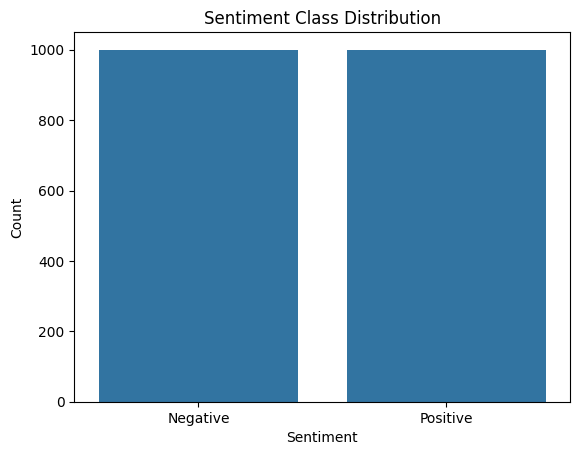

In [5]:

sns.countplot(x=labels)
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


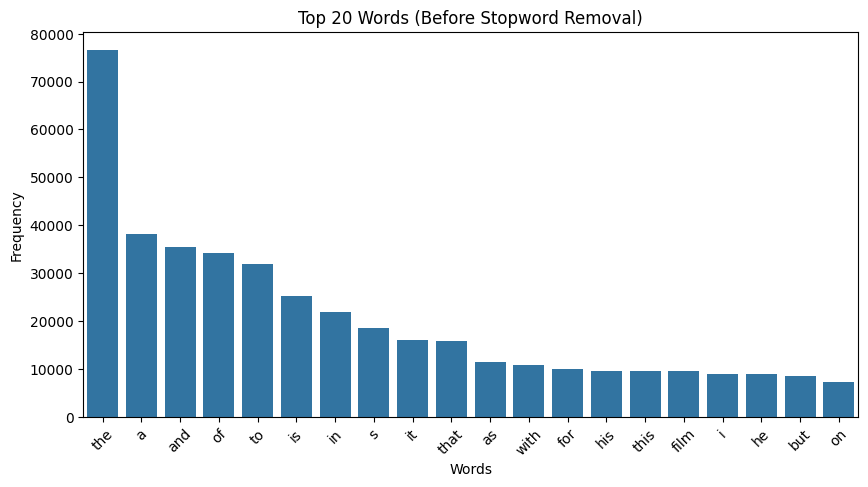

In [6]:
from nltk import FreqDist

all_words = [w.lower() for words, _ in docs for w in words if w.isalpha()]
freq_dist = FreqDist(all_words)
common_words = freq_dist.most_common(20)

words, freqs = zip(*common_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(words), y=list(freqs))
plt.xticks(rotation=45)
plt.title('Top 20 Words (Before Stopword Removal)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


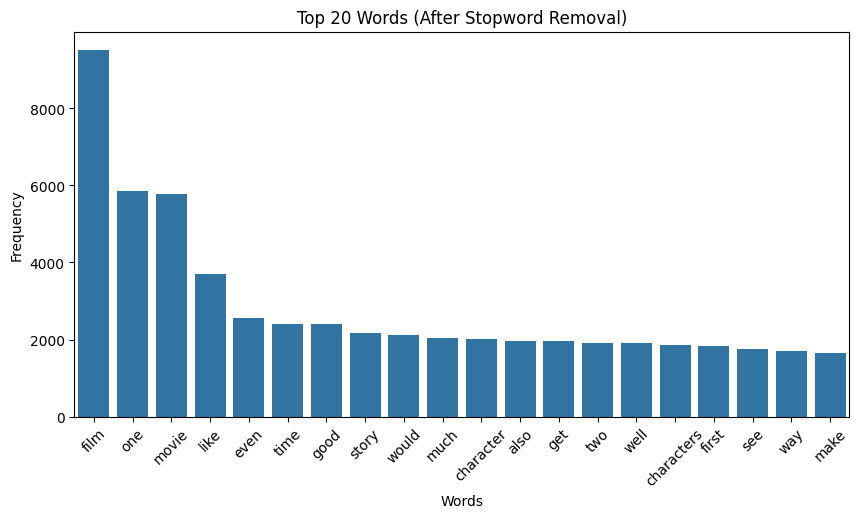

In [7]:
stop_words = set(stopwords.words('english'))
filtered_words = [w for w in all_words if w not in stop_words]
filtered_freq_dist = FreqDist(filtered_words)
filtered_common_words = filtered_freq_dist.most_common(20)

words, freqs = zip(*filtered_common_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(words), y=list(freqs))
plt.xticks(rotation=45)
plt.title('Top 20 Words (After Stopword Removal)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


In [8]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(texts)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [9]:
lr_model = LogisticRegression(max_iter=1000)
nb_model = MultinomialNB()
svm_model = SVC(kernel='linear', probability=True)

lr_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)


SVC(kernel='linear', probability=True)

In [10]:
y_pred_lr = lr_model.predict(X_test)
y_pred_nb = nb_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)


In [11]:
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

print("Naive Bayes Report:")
print(classification_report(y_test, y_pred_nb))

print("SVM Report:")
print(classification_report(y_test, y_pred_svm))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       200
           1       0.83      0.86      0.84       200

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400

Naive Bayes Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       200
           1       0.84      0.78      0.81       200

    accuracy                           0.81       400
   macro avg       0.82      0.81      0.81       400
weighted avg       0.82      0.81      0.81       400

SVM Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       200
           1       0.84      0.91      0.87       200

    accuracy                           0.86       400
   macro avg       0.87      0.86      0.86       400
weighted avg  

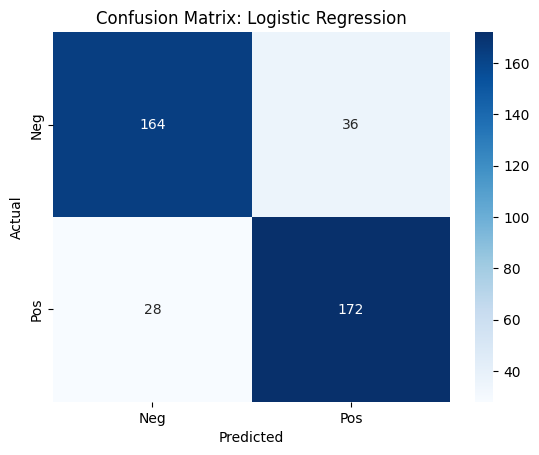

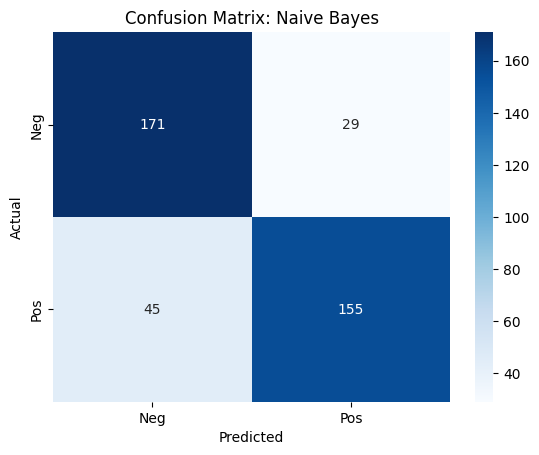

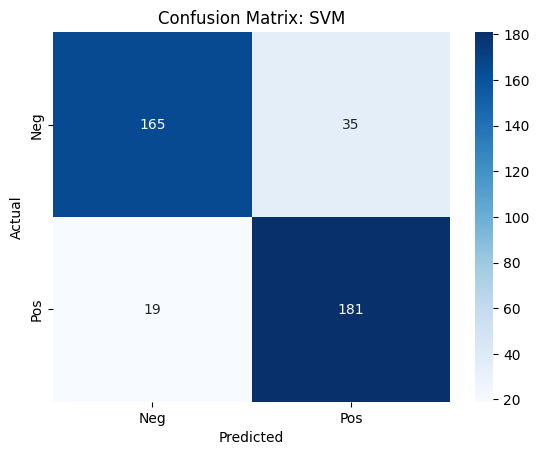

In [12]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_conf_matrix(y_test, y_pred_lr, "Logistic Regression")
plot_conf_matrix(y_test, y_pred_nb, "Naive Bayes")
plot_conf_matrix(y_test, y_pred_svm, "SVM")


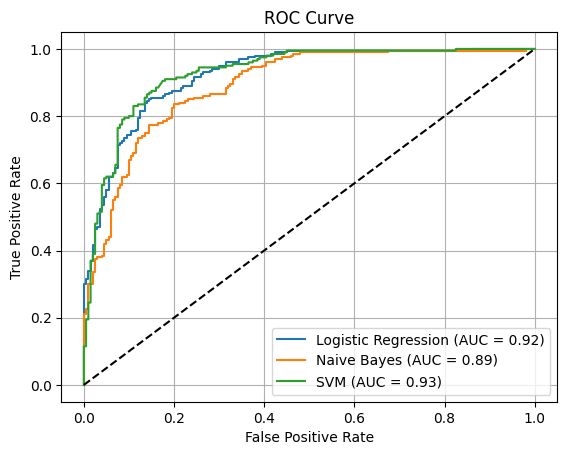

In [13]:
def plot_roc_curve(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.figure()
plot_roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1], "Logistic Regression")
plot_roc_curve(y_test, nb_model.predict_proba(X_test)[:, 1], "Naive Bayes")
plot_roc_curve(y_test, svm_model.predict_proba(X_test)[:, 1], "SVM")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()
